In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

In [3]:
# функция для сохранения файлов формата json
def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

In [4]:
# Функция для разделения признаков на числовые и категориальные
def separation(fn,df):
    num_cols = [c for c in fn if pd.api.types.is_numeric_dtype(df[c])] 
    cat_cols = [c for c in fn if df[c].dtype == 'O']
    return num_cols,cat_cols
    

In [5]:
# Построение Pipline модели с препроцессингом
def pipline(num_cols,cat_cols):
    #для числовых признаков избавляемся от пропусков,стандартизируем данные
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()), 
    ])
    #для категориальных признаков также избавляемся от пропусков и кодируем данные
    categorical_transformer = Pipeline(steps=[
        ('imputer' , SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    #объединяем в один "констурктор"
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])
    return preprocessor

In [6]:
# Построение модели KMeans с подбором параметра K
def compute_metrics_over_k(X, k_values,preprocessor):
    results = {
        'k_values': k_values,
        'silhouette': [],
        'davies_bouldin': [],
        'calinski_harabasz': [],
    }

    for k in k_values:
        # Создаем pipeline
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('cluster', KMeans(n_clusters=k, random_state=42, n_init="auto"))
        ])
        
        # Обучаем и получаем метки
        labels = model.fit_predict(X)
        
        # Преобразуем данные для метрик
        X_transformed = model.named_steps['preprocessor'].transform(X)
        
        # Вычисляем метрики
        results['silhouette'].append(silhouette_score(X_transformed, labels))
        results['davies_bouldin'].append(davies_bouldin_score(X_transformed, labels))
        results['calinski_harabasz'].append(calinski_harabasz_score(X_transformed, labels))

    return results

k_values = list(range(2, 21))

In [7]:
# Визуализация внутренних метрик для модели KMeans и сохранение Silhouette в папку.
def visualition_k_means(results,path):
    plt.figure(figsize=(7, 4))
    plt.plot(results['k_values'], results['silhouette'], marker="o")
    plt.title("Silhouette vs k (higher is better)")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.25) 
    plt.savefig(path, dpi=100,bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(results['k_values'], results['davies_bouldin'], marker="o")
    plt.title("Davies-Bouldin vs k (lower is better)")
    plt.xlabel("k")
    plt.ylabel("davies_bouldin")
    plt.grid(True, alpha=0.25)
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(results['k_values'], results['calinski_harabasz'], marker="o")
    plt.title("Calinski-Harabasz vs k (higher is better)")
    plt.xlabel("k")
    plt.ylabel("calinski_harabasz")
    plt.grid(True, alpha=0.25)
    plt.show()


In [8]:
# Построение модели Agglomerative с подбором параметров
agg_ks = list(range(2, 21))
agg_linkages = ["ward", "complete"]
def eval_agglomerative_grid(X, agg_ks, agg_linkages,preprocessor):
    results_agg = {
        'agg_ks': agg_ks,
        'agg_linkages': agg_linkages,
        'silhouette': [],
        'davies_bouldin': [],
        'calinski_harabasz': [],
        
    }
    for linkage_name in agg_linkages:
        for k in agg_ks:
            # Создаем pipeline
            model = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('cluster', AgglomerativeClustering(n_clusters=k, linkage=linkage_name))
            ])
        
            # Обучаем и получаем метки
            labels = model.fit_predict(X)
        
            # Преобразуем данные для метрик
            X_transformed = model.named_steps['preprocessor'].transform(X)
        
            # Вычисляем метрики
            results_agg['silhouette'].append(silhouette_score(X_transformed, labels))
            results_agg['davies_bouldin'].append(davies_bouldin_score(X_transformed, labels))
            results_agg['calinski_harabasz'].append(calinski_harabasz_score(X_transformed, labels))
            

    return results_agg

In [9]:
# Визуализация внутренних метрик для модели Agglomerative и сохранение Silhouette в папку.
def plot_silhouette_by_linkage(results, agg_linkages,path):
    
    plt.figure(figsize=(7, 4))
    
    ks = results['agg_ks']
    silhouette_all = results['silhouette']
    k_count = len(ks)
    
    for idx, linkage_name in enumerate(agg_linkages):
        start_idx = idx * k_count
        end_idx = start_idx + k_count
        sil = silhouette_all[start_idx:end_idx]
        plt.plot(ks, sil, marker="o", label=linkage_name)
    
    plt.title("Agglomerative: silhouette vs k (by linkage)")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.savefig(path, dpi=100,bbox_inches='tight')
    plt.show()

def plot_davies_bouldin_by_linkage(results, agg_linkages):
    
    plt.figure(figsize=(7, 4))
    
    ks = results['agg_ks']
    db_all = results['davies_bouldin']
    k_count = len(ks)
    
    for idx, linkage_name in enumerate(agg_linkages):
        start_idx = idx * k_count
        end_idx = start_idx + k_count
        db = db_all[start_idx:end_idx]
        plt.plot(ks, db, marker="o", label=linkage_name)
    
    plt.title("Agglomerative: Davies-Bouldin vs k (by linkage)")
    plt.xlabel("k")
    plt.ylabel("davies_bouldin")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()

def plot_calinski_harabasz_by_linkage(results, agg_linkages):
    
    plt.figure(figsize=(7, 4))
    
    ks = results['agg_ks']
    ch_all = results['calinski_harabasz']
    k_count = len(ks)
    
    for idx, linkage_name in enumerate(agg_linkages):
        start_idx = idx * k_count
        end_idx = start_idx + k_count
        ch = ch_all[start_idx:end_idx]
        plt.plot(ks, ch, marker="o", label=linkage_name)
    
    plt.title("Agglomerative: Calinski-Harabasz vs k (by linkage)")
    plt.xlabel("k")
    plt.ylabel("calinski_harabasz")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()


In [10]:
# Построение модели DBSCAN с подбором параметров
dbscan_eps = [1.5, 2.0, 2.5, 3.0, 3.5]
dbscan_min_samples = [3, 5, 10]
def eval_dbscan_grid(X, dbscan_eps, dbscan_min_samples,preprocessor):
    results_dbscan = {
        'dbscan_eps': dbscan_eps,
        'dbscan_min_samples': dbscan_min_samples,
        'silhouette': [],
        'davies_bouldin': [],
        'calinski_harabasz': [],
        'n_clusters': [],      
        'noise_frac': [],      
        'n_non_noise': [] 
        
    }
    for eps in dbscan_eps:
        for ms in dbscan_min_samples:
            # Создаем pipeline
            model = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('cluster', DBSCAN(eps=eps, min_samples=ms))
            ])
        
            # Обучаем и получаем метки
            labels = model.fit_predict(X)

            # Преобразуем данные для метрик
            X_transformed = model.named_steps['preprocessor'].transform(X)

            # Отделяем шум 
            noise_mask = labels == -1
            noise_frac = float(np.mean(noise_mask))
            non_noise_mask = labels != -1
            n_non_noise = sum(non_noise_mask)
            
           
            labels_nn = labels[non_noise_mask]
            X_nn = X_transformed[non_noise_mask]  # используем преобразованные данные!

            n_clusters = len(np.unique(labels_nn)) if len(labels_nn) > 0 else 0

            # Если достаточно данных → вычисляем метрики
            if len(np.unique(labels_nn)) >= 2:  
                # Перенумеровываем метки 
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn_renum = np.array([mapping[v] for v in labels_nn])
    
                # Вычисляем метрики
                sil = silhouette_score(X_nn, labels_nn_renum)
                db = davies_bouldin_score(X_nn, labels_nn_renum)
                ch = calinski_harabasz_score(X_nn, labels_nn_renum)
            else:
                sil, db, ch = np.nan, np.nan, np.nan  # metrics = None
            
    
            results_dbscan['silhouette'].append(sil)
            results_dbscan['davies_bouldin'].append(db)
            results_dbscan['calinski_harabasz'].append(ch)
            results_dbscan['n_clusters'].append(n_clusters)
            results_dbscan['noise_frac'].append(noise_frac)
            results_dbscan['n_non_noise'].append(n_non_noise)
            

    return results_dbscan

In [11]:
# Сводка метрик для модели DBSCAN
def metrics_dbscan(results_dbscan):
    # Посмотрим, какие варианты вообще дали >=2 кластера
    valid_indices = [i for i, sil in enumerate(results_dbscan['silhouette'])
                     if not np.isnan(sil)]
    print("Valid DBSCAN configs:", len(valid_indices))

    # Собираем данные для сортировки
    valid = []
    for idx in valid_indices:
        # Определяем параметры по индексу
        ms_count = len(dbscan_min_samples)
        eps_idx = idx // ms_count
        ms_idx = idx % ms_count

        valid.append({
            'params': {'eps': dbscan_eps[eps_idx], 'min_samples': dbscan_min_samples[ms_idx]},
            'metrics': {
                'silhouette': results_dbscan['silhouette'][idx],
                'davies_bouldin': results_dbscan['davies_bouldin'][idx],
                'calinski_harabasz': results_dbscan['calinski_harabasz'][idx]
            },
            'n_clusters': results_dbscan['n_clusters'][idx],
            'noise_frac': results_dbscan['noise_frac'][idx],
            'n_non_noise': results_dbscan['n_non_noise'][idx]
        })

    # Сортировка по silhouette
    valid_sorted = sorted(valid, key=lambda r: r['metrics']['silhouette'], reverse=True)

    # Вывод топ-8
    for r in valid_sorted[:8]:
        return valid_sorted

In [12]:
# PCA(2D) scatter для лучшей модели DBSCAN
def PCA_2D(best_model,X,path):
    labels = best_model.fit_predict(X)
    X_transformed = best_model.named_steps['preprocessor'].transform(X)
    X_pca2 = PCA(n_components=2).fit_transform(X_transformed)

    plt.figure(figsize=(7, 5))
    plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=labels, cmap='tab10', s=30, alpha=0.7)
    plt.title("DBSCAN кластеризация")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, alpha=0.25)
    plt.savefig(path, dpi=100,bbox_inches='tight')
    plt.show()

In [13]:
# PCA(2D) scatter для лучшей модели k-means
def PCA_2D_k_means(best_model,X,path):
    labels = best_model.fit_predict(X)
    X_transformed = best_model.named_steps['preprocessor'].transform(X)
    X_pca2 = PCA(n_components=2).fit_transform(X_transformed)

    plt.figure(figsize=(7, 5))
    plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=labels, cmap='tab10', s=30, alpha=0.7)
    plt.title("k-means кластеризация")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, alpha=0.25)
    plt.savefig(path, dpi=100,bbox_inches='tight')
    plt.show()

РАБОТА С ДАТАСЕТОМ 1

In [29]:
df1 = pd.read_csv('S07-hw-dataset-01.csv')
df1.info()
df1.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213
5,5,-9.155108,80.803958,-0.023064,-42.562391,2.681999,-10.450216,52.285727,0.134157
6,6,-13.414198,-45.224459,0.016343,23.198649,0.275342,4.845267,40.734814,0.040547
7,7,-15.303931,-39.539061,0.198038,21.117504,0.334350,1.308574,17.347164,0.378773
8,8,-15.154668,-34.099503,0.215049,18.059247,1.937555,2.834771,-87.429349,-0.191803
9,9,0.673476,-82.966506,-0.066941,70.082996,-11.262309,-7.221289,-28.222359,-0.383327


In [30]:
df1.describe()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


Пропуски отсутвуют,все признаки числовые.

In [31]:
fn1 = df1.columns[1:9].tolist()
X = df1[fn1] # признаки(без sample_id).
y_true1 = df1['sample_id'] 
print(f"Признаки: {fn1}")
print(f"y_true: {'sample_id'}")

Признаки: ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08']
y_true: sample_id


In [32]:
#Разделяем признаки на числовые и категориальные

num_cols1,cat_cols1 = separation(fn1,df1)

In [10]:
# Модель K-means для 1го датасета
results1 = compute_metrics_over_k(X, k_values,pipline(num_cols1,cat_cols1))

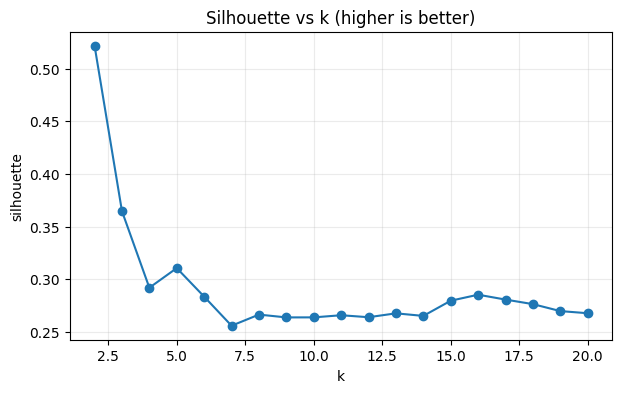

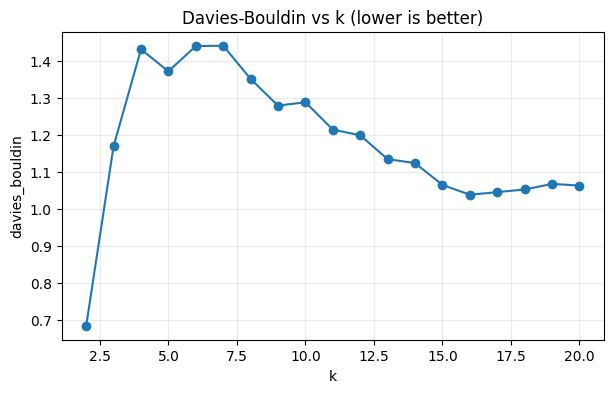

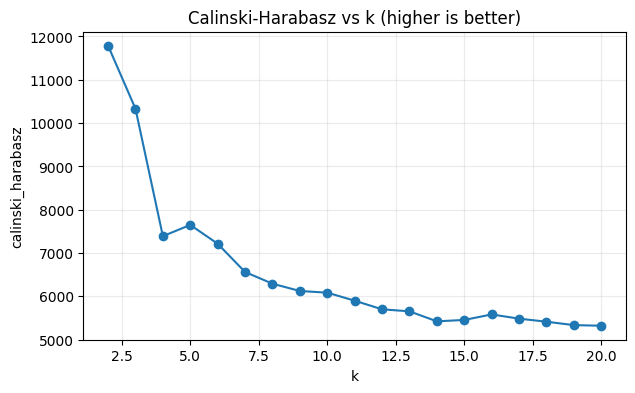

In [14]:
# Визуализация и сохранение метрик для 1го датасета
visualition_k_means(results1,"artifacts/figures/silhouette_for_KMeans_dataset_01.png")

In [172]:
#Находим оптимальное k по графику

# максимальное значение по метрике'silhouette'(оно также минимальное для 'davies_bouldin' и максимальное для Calinski-Harabasz(это видно по графикам))
k_for_max_sil = results1['k_values'][results1['silhouette'].index(max(results1['silhouette']))] 

sil = results1['silhouette'][ results1['k_values'].index(k_for_max_sil)]
db = results1['davies_bouldin'][ results1['k_values'].index(k_for_max_sil)]
ch = results1['calinski_harabasz'][ results1['k_values'].index(k_for_max_sil)]


print(f"Метрики для k = {k_for_max_sil}:")
print(f"Silhouette: {sil}")
print(f"Davies-Bouldin: {db}")
print(f"Calinski-Harabasz: {ch}")


Метрики для k = 2:
Silhouette: 0.5216395622404242
Davies-Bouldin: 0.6853295219054459
Calinski-Harabasz: 11786.95462267153


In [243]:
#проверка усточивости по random_state
k_values = list(range(2, 21))
random_state = [42,56,78,90,100]
for i in random_state:
    results = {
        'k_values': k_values,
        'silhouette': [],
        'davies_bouldin': [],
        'calinski_harabasz': [],
    }

    for k in k_values:
        # Создаем pipeline
        model = Pipeline(steps=[
            ('preprocessor', pipline(num_cols1,cat_cols1)),
            ('cluster', KMeans(n_clusters=k, random_state=i, n_init="auto"))
        ])

        # Обучаем и получаем метки
        labels = model.fit_predict(X)

        # Преобразуем данные для метрик
        X_transformed = model.named_steps['preprocessor'].transform(X)

        # Вычисляем метрики
        results['silhouette'].append(silhouette_score(X_transformed, labels))
        results['davies_bouldin'].append(davies_bouldin_score(X_transformed, labels))
        results['calinski_harabasz'].append(calinski_harabasz_score(X_transformed, labels))

    
    # Находим оптимальное k по графику

    # максимальное значение по метрике'silhouette'(оно также минимальное для 'davies_bouldin' и максимальное для Calinski-Harabasz(это видно по графикам))
    k_for_max_sil = results['k_values'][results['silhouette'].index(max(results['silhouette']))]

    sil = results['silhouette'][results['k_values'].index(k_for_max_sil)]
    db = results['davies_bouldin'][results['k_values'].index(k_for_max_sil)]
    ch = results['calinski_harabasz'][results['k_values'].index(k_for_max_sil)]

    print(f"Метрики для k = {k_for_max_sil}:")
    print(f"Silhouette: {sil}")
    print(f"Davies-Bouldin: {db}")
    print(f"Calinski-Harabasz: {ch}")


Метрики для k = 2:
Silhouette: 0.5216395622404242
Davies-Bouldin: 0.6853295219054459
Calinski-Harabasz: 11786.95462267153
Метрики для k = 2:
Silhouette: 0.5216395622404242
Davies-Bouldin: 0.6853295219054459
Calinski-Harabasz: 11786.95462267153
Метрики для k = 2:
Silhouette: 0.5216395622404242
Davies-Bouldin: 0.6853295219054459
Calinski-Harabasz: 11786.95462267153
Метрики для k = 2:
Silhouette: 0.5216395622404242
Davies-Bouldin: 0.6853295219054459
Calinski-Harabasz: 11786.95462267153
Метрики для k = 2:
Silhouette: 0.5216395622404242
Davies-Bouldin: 0.6853295219054459
Calinski-Harabasz: 11786.95462267153


модель абсолютно устойчива, параметр random_state никак не влияет на результат.

In [173]:
# Создание словаря со сводками метрик и моделей для каждого датасета
best_parametrs = {
    "dt_1":{
        "K-means":{
            "Метрики для k": k_for_max_sil,
            "Silhouette" : sil,
            "Davies-Bouldin" : db,
            "Calinski-Harabasz" : ch
        }
    },
    "dt_2": {
    },
    "dt_4": {
    }
}
save_json(best_parametrs, Path("artifacts/metrics_summary.json"))

In [21]:
# Построение модели Agglomerative для датасета 1
results_agg1 = eval_agglomerative_grid(X, agg_ks, agg_linkages,pipline(num_cols1,cat_cols1))

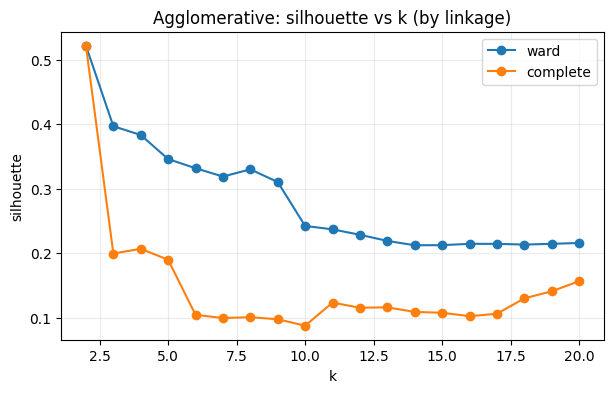

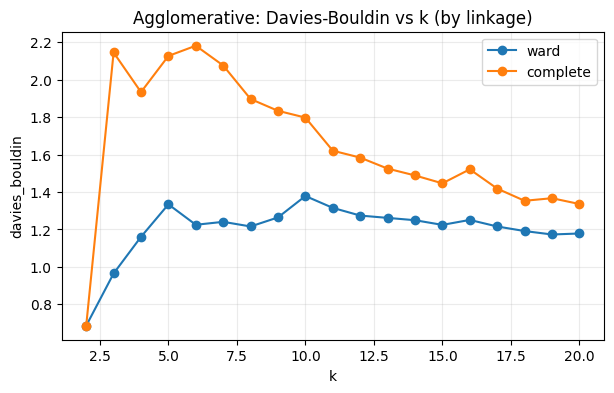

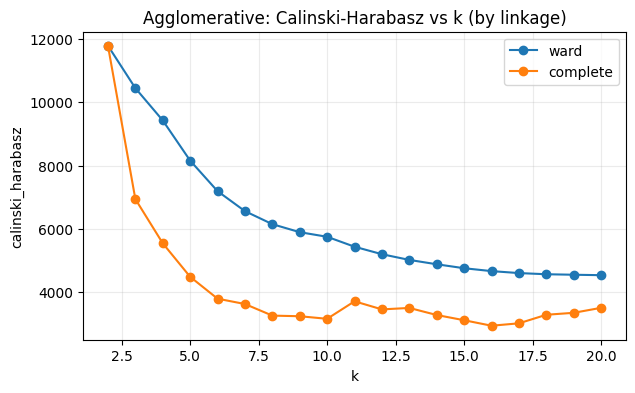

In [25]:
# Визуализация и сохранение метрик для датасета 1
plot_silhouette_by_linkage(results_agg1, agg_linkages,"artifacts/figures/silhouette_for_Agglomerative_dataset_01.png")
plot_davies_bouldin_by_linkage(results_agg1, agg_linkages)
plot_calinski_harabasz_by_linkage(results_agg1, agg_linkages)

По графику можно определить , что оптимальное значение также k = 2, причем при linkage = ward, анализируя по другим значениям.

In [27]:
k_for_max_sil = 2
sil = results_agg1['silhouette'][results_agg1['agg_ks'].index(k_for_max_sil)]
db = results_agg1['davies_bouldin'][results_agg1['agg_ks'].index(k_for_max_sil)]
ch = results_agg1['calinski_harabasz'][results_agg1['agg_ks'].index(k_for_max_sil)]

print(f"Метрики для k = {k_for_max_sil}: , linkage = ward")
print(f"Silhouette: {sil}")
print(f"Davies-Bouldin: {db}")
print(f"Calinski-Harabasz: {ch}")


Метрики для k = 2: , linkage = ward
Silhouette: 0.5216395622404242
Davies-Bouldin: 0.6853295219054459
Calinski-Harabasz: 11786.95462267153


In [174]:
# Обновляем словарь с результатами всех метрик
json_path = Path("artifacts/metrics_summary.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)
existing_results["dt_1"]["Agglomerative"] = {
    
        "Метрики для k": k_for_max_sil,
        "Silhouette":sil,
        "Davies-Bouldin": db,
        "Calinski-Harabasz": ch
    
}
save_json(existing_results, json_path)

In [37]:
# создание модели DBSCAN для 1 датасета
results_dbscan1 = eval_dbscan_grid(X, dbscan_eps, dbscan_min_samples,pipline(num_cols1,cat_cols1))

In [125]:
# сводка метрик для датасета 1
metrics_dbscan(results_dbscan1)

Valid DBSCAN configs: 9


[{'params': {'eps': 2.0, 'min_samples': 3},
  'metrics': {'silhouette': 0.5216395622404242,
   'davies_bouldin': 0.6853295219054459,
   'calinski_harabasz': 11786.95462267153},
  'n_clusters': 2,
  'noise_frac': 0.0,
  'n_non_noise': np.int64(12000)},
 {'params': {'eps': 2.0, 'min_samples': 5},
  'metrics': {'silhouette': 0.5216395622404242,
   'davies_bouldin': 0.6853295219054459,
   'calinski_harabasz': 11786.95462267153},
  'n_clusters': 2,
  'noise_frac': 0.0,
  'n_non_noise': np.int64(12000)},
 {'params': {'eps': 2.0, 'min_samples': 10},
  'metrics': {'silhouette': 0.5216395622404242,
   'davies_bouldin': 0.6853295219054459,
   'calinski_harabasz': 11786.95462267153},
  'n_clusters': 2,
  'noise_frac': 0.0,
  'n_non_noise': np.int64(12000)},
 {'params': {'eps': 2.5, 'min_samples': 3},
  'metrics': {'silhouette': 0.5216395622404242,
   'davies_bouldin': 0.6853295219054459,
   'calinski_harabasz': 11786.95462267153},
  'n_clusters': 2,
  'noise_frac': 0.0,
  'n_non_noise': np.int64(

лучшая модель по свовдке с парметрами 'eps': 2.0, 'min_samples': 3 , но на самом деле можно взять и другие , тк совпали метрики у многих.

In [175]:
# обновление словаря с результатами всех метрик
json_path = Path("artifacts/metrics_summary.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)

existing_results["dt_1"]["DBSCAN"] = {
    'metrics': {
        'silhouette': 0.5216395622404242,
        'davies_bouldin': 0.6853295219054459,
        'calinski_harabasz': 11786.95462267153
    },
    'n_clusters': 2,
    'noise_frac': 0.0,
    'n_non_noise': 12000
}
save_json(existing_results, json_path)

По итогу все 3 модели показали одинаковый результат,разделив данные всего на два класса, это как раз совместимо с неточными значениями метрик.Это можно связать с малым колличеством признаков в нашем датасете, всего лишь 8, для задач кластеризации это очень мало. В качестве лучшей модели выберу модель DBSCAN , тк она более сложная и учитывает шум.

In [33]:
#лучшая модель для датасета 1
best_model1 = Pipeline(steps=[
    ('preprocessor', pipline(num_cols1,cat_cols1)),
    ('cluster', DBSCAN(eps=2, min_samples=5)) # min_samples взяли средний при одинаковых остальных значениях
])
labels1 = best_model1.fit_predict(X)

In [34]:
#создание и сохранение CSV-файла с присвоенными кластерами
df11 = pd.DataFrame({
    'sample_id': y_true1,
    'cluster_label': labels1
})
df11.to_csv('artifacts/labels/labels_hw07_ds1.csv', index=False)

In [188]:
# Создание словаря с лучшими параметрами для каждого датасета
best_parametrs = {
    "dt_1":{
        "DBSCAN":{
            'eps': 2.0,
            'min_samples': 5
        }
    },
    "dt_2":{
    
    },
    "dt_4":{
    
    }
}
save_json(best_parametrs, Path("artifacts/best_configs.json"))

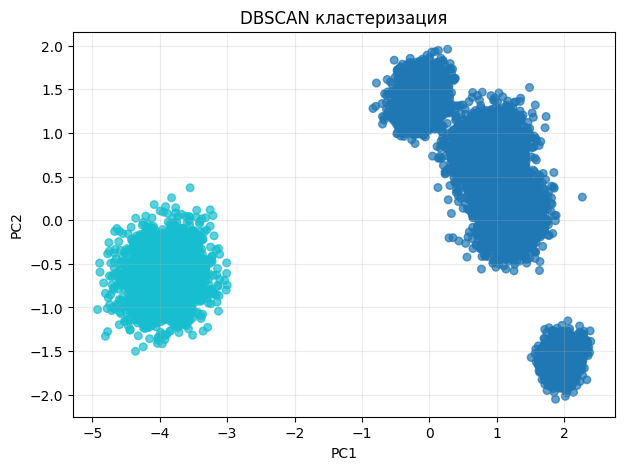

In [117]:
# PCA(2D) scatter для лучшей модели датасета 1
PCA_2D(best_model1,X,"artifacts/figures/PCA(2D)_scatter_for_best_model_dataset_01.png")

РАБОТА С ДАТАСЕТОМ 2

In [20]:
df2 = pd.read_csv('S07-hw-dataset-02.csv')
df2.info()
df2.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472
5,5,-0.932356,2.894645,-9.150930
6,6,0.117411,0.834173,4.382666
7,7,1.024343,-1.421237,-3.629838
8,8,-0.468618,-0.296113,-9.568211
9,9,-1.231242,-1.213089,-7.716715


Пропуски отсутвуют,все признаки числовые.

In [21]:
df2.describe()

,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


In [26]:
fn2 = df2.columns[1:4].tolist()
X1 = df2[fn2] # признаки(без sample_id).

y_true2 = df2['sample_id'] 
print(f"Признаки: {fn2}")
print(f"y_true: {'sample_id'}")

Признаки: ['x1', 'x2', 'z_noise']
y_true: sample_id


In [23]:
num_cols2,cat_cols2 = separation(fn2,df2)

In [98]:
# Построение модели K-means для датасета 2
results2 = compute_metrics_over_k(X1, k_values,pipline(num_cols2,cat_cols2))

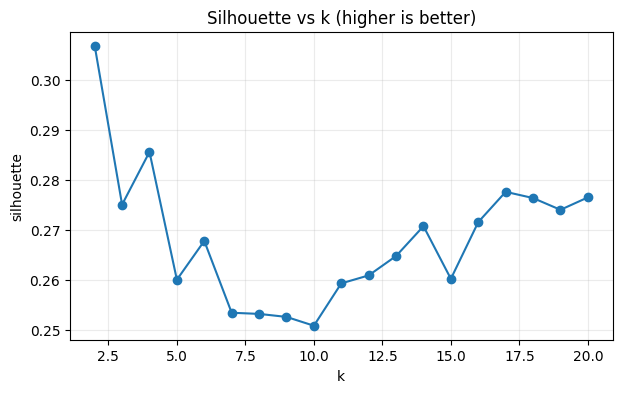

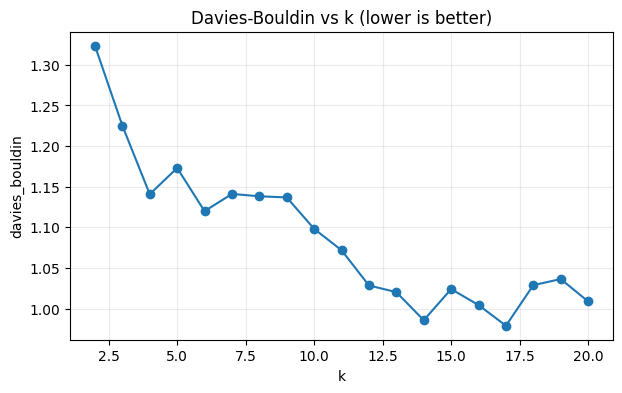

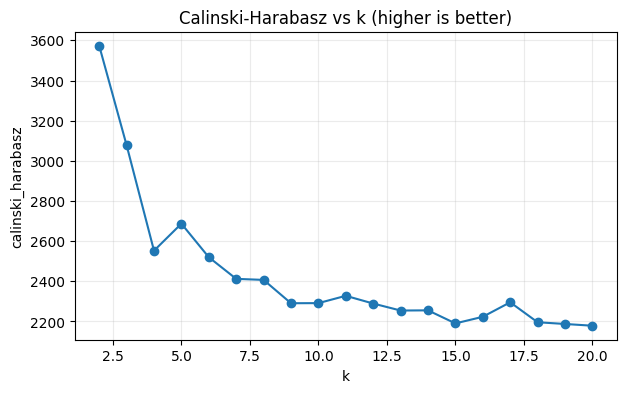

In [100]:
visualition_k_means(results2,"artifacts/figures/silhouette_for_KMeans_dataset_02.png")

Анализируя графики, получаем , что наилушее значние K = 2,однако вид второго графика заставляет сомневаться в справидливости модели, поэтому визуализируем эту модель.

In [103]:
#Находим оптимальное k по графику

# максимальное значение по метрике'silhouette'(оно также минимальное для 'davies_bouldin' и максимальное для Calinski-Harabasz(это видно по графикам))
k_for_max_sil1 = results2['k_values'][results2['silhouette'].index(max(results2['silhouette']))] 

sil1 = results2['silhouette'][ results2['k_values'].index(k_for_max_sil)]
db1 = results2['davies_bouldin'][ results2['k_values'].index(k_for_max_sil)]
ch1 = results2['calinski_harabasz'][ results2['k_values'].index(k_for_max_sil)]


print(f"Метрики для k = {k_for_max_sil1}:")
print(f"Silhouette: {sil1}")
print(f"Davies-Bouldin: {db1}")
print(f"Calinski-Harabasz: {ch1}")


Метрики для k = 2:
Silhouette: 0.3068610017701601
Davies-Bouldin: 1.3234721699867644
Calinski-Harabasz: 3573.3933329348392


In [176]:
# Обновляем словарь с результатами всех метрик
json_path = Path("artifacts/metrics_summary.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)
existing_results["dt_2"]["K-means"] = {
    
        "Метрики для k": k_for_max_sil1,
        "Silhouette":sil1,
        "Davies-Bouldin": db1,
        "Calinski-Harabasz": ch1
    
}
save_json(existing_results, json_path)

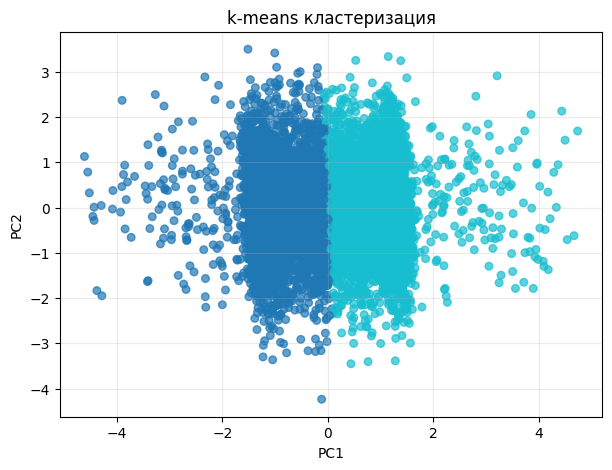

In [152]:
#визуализация модели K-means 
model2 = Pipeline(steps=[
            ('preprocessor', pipline(num_cols2,cat_cols2)),
            ('cluster', KMeans(n_clusters=2, random_state=42, n_init="auto"))
        ])
PCA_2D_k_means(model2,X1,"artifacts/figures/PCA(2D)_scatter_for_bad_model_dataset_02.png")

Как мы и предпологали, модель определила кластеры плохо,исскуственно разделив единый кластер на два,докажем это, построив модель dbscan

In [122]:
# создание модели dbscan для 2 датасета
results_dbscan2 = eval_dbscan_grid(X1, dbscan_eps, dbscan_min_samples,pipline(num_cols2,cat_cols2))

In [126]:
metrics_dbscan(results_dbscan2)

Valid DBSCAN configs: 0


Да,действительно , модель показвает что ей не удалось найти 2 и более кластера,это показывает что модель K-means уязвима на шумовые данные, в отличие от модели dbscan, которая по плотности определила что кластер един, несмотря на шум, поэтому для данного датасета лучшей модели будет модель dbscan,которая не разделяет ложно два кластера.

In [239]:
#Покажем справидливость своих доводов
print(results_dbscan2['n_clusters'])
print(results_dbscan2['noise_frac'])
print(results_dbscan2['n_non_noise'])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0.0, 0.0, 0.000125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[np.int64(8000), np.int64(8000), np.int64(7999), np.int64(8000), np.int64(8000), np.int64(8000), np.int64(8000), np.int64(8000), np.int64(8000), np.int64(8000), np.int64(8000), np.int64(8000), np.int64(8000), np.int64(8000), np.int64(8000)]


In [240]:
# обновление словаря с результатами всех метрик
json_path = Path("artifacts/metrics_summary.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)

existing_results["dt_2"]["DBSCAN"] = {
    'metrics': {
        'silhouette':  None,
        'davies_bouldin': None,
        'calinski_harabasz': None
    },
    'n_clusters': 1,
    'noise_frac': 0.0,
    'n_non_noise': 8000
}
save_json(existing_results, json_path)

In [24]:
best_model2 = Pipeline(steps=[
    ('preprocessor', pipline(num_cols2,cat_cols2)),
    ('cluster', DBSCAN(eps=2, min_samples=5)) # min_samples и eps любые из заданного диапазона 
])
labels2 = best_model2.fit_predict(X1)

In [28]:
#создание и сохранение CSV-файла с присвоенными кластерами
df22 = pd.DataFrame({
    'sample_id': y_true2,
    'cluster_label': labels2
})
df22.to_csv('artifacts/labels/labels_hw07_ds2.csv', index=False)

In [189]:
# Обновление словаря с лучшими параметрами для каждого датасета
json_path = Path("artifacts/best_configs.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)

existing_results["dt_2"] = {
    "DBSCAN":{
            'eps': 2.0,
            'min_samples': 5
        }
}
save_json(existing_results, json_path)

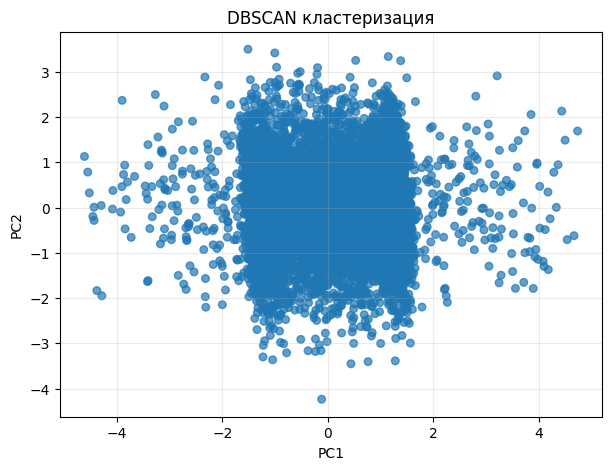

In [147]:
PCA_2D(best_model2,X1,"artifacts/figures/PCA(2D)_scatter_for_best_model_dataset_02.png")

РАБОТА С ДАТАСЕТОМ 4

In [14]:
df4 = pd.read_csv('S07-hw-dataset-04.csv')
df4.info()
df4.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  10000 non-null  int64  
 1   cat_a      10000 non-null  object 
 2   cat_b      10000 non-null  object 
 3   n01        9826 non-null   float64
 4   n02        9811 non-null   float64
 5   n03        9801 non-null   float64
 6   n04        9808 non-null   float64
 7   n05        9799 non-null   float64
 8   n06        9817 non-null   float64
 9   n07        9796 non-null   float64
 10  n08        9806 non-null   float64
 11  n09        9805 non-null   float64
 12  n10        9811 non-null   float64
 13  n11        9796 non-null   float64
 14  n12        9798 non-null   float64
 15  n13        9803 non-null   float64
 16  n14        9802 non-null   float64
 17  n15        9814 non-null   float64
 18  n16        9809 non-null   float64
 19  n17        9788 non-null   float64
 20  n18    

,sample_id,cat_a,cat_b,n01,n02,n03,n04,n05,n06,n07,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
0,0,B,X,-4.827501,-24.507466,-7.852963,0.771781,28.297884,-4.493911,-42.769449,...,24.597176,-26.354320,4.543397,-19.549036,-3.051332,-5.538587,-3.084457,5.499629,-6.128896,3.132067
1,1,F,V,51.302500,NaN,5.534737,51.305464,-8.027553,28.297548,NaN,...,-18.216260,8.527932,17.202115,-30.452260,0.855326,1.199066,3.597555,-2.239703,2.932710,0.473145
2,2,A,W,-4.820828,-2.625385,27.891578,1.523041,-5.776687,-16.298523,2.462937,...,-48.260775,9.313232,12.323411,55.081325,-3.945606,-0.280540,-0.130583,-7.353205,-2.942836,1.460477
3,3,B,X,-2.627573,-25.063639,-9.450011,-8.344669,22.371118,-11.525848,-43.762607,...,24.700663,-25.466915,-3.398665,-18.174541,0.438229,3.152556,3.859283,-2.678769,-2.213923,-4.724639
4,4,C,Y,-11.415710,-8.692169,48.636163,14.661826,-39.634618,10.769075,40.187536,...,-79.710383,-13.694253,41.575892,-9.498640,1.529608,-1.641347,3.500090,3.111257,1.475232,-1.321676
5,5,C,Y,NaN,-6.568176,48.321294,14.087974,-37.952812,10.285660,38.682861,...,-76.537851,-10.745350,40.930772,-7.135282,3.277449,-0.007331,0.720048,-5.804991,1.136804,0.129350
6,6,F,Y,-11.494178,-5.632114,49.332532,13.675489,-39.221865,11.170254,42.317318,...,-77.382721,-10.612934,39.408249,-7.439799,-0.346658,-1.760743,-4.634182,-0.180436,-6.503820,-0.701660
7,7,E,U,29.509838,34.898300,-22.253684,0.598944,21.346214,11.371536,-13.184219,...,20.362487,15.401255,-17.545954,19.334069,-1.704104,3.928554,5.608148,-4.573262,2.345244,-2.008675
8,8,F,V,56.366753,-2.791186,1.264317,45.268076,-0.066137,31.755385,12.780097,...,-4.186373,10.040766,18.300005,-34.899137,-1.436598,-1.489694,3.887254,-0.356854,1.255438,-5.024669
9,9,A,W,7.475065,2.402914,33.931401,4.647808,NaN,-10.726027,6.825630,...,-39.461697,9.905740,7.597248,45.097071,-3.448577,-1.675175,-0.006618,2.005015,-1.767238,4.194457


Имеются пропуски и категориальные данные,предобработаем их далее через мою паплайн модель, она универсалльна.

In [15]:
df4.describe()

,sample_id,n01,n02,n03,n04,n05,n06,n07,n08,n09,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
count,10000.00000,9826.000000,9811.000000,9801.000000,9808.000000,9799.000000,9817.000000,9796.000000,9806.000000,9805.000000,...,9785.000000,9804.000000,9829.000000,9793.000000,9815.000000,9776.000000,9803.000000,9789.000000,9798.000000,9805.000000
mean,4999.50000,17.348435,-2.057620,7.908302,14.269157,0.900590,5.832787,-0.840875,-4.888128,3.184200,...,-12.716502,-0.506241,8.360226,0.026943,0.039297,-0.037155,0.028512,-0.030738,-0.018685,-0.030254
std,2886.89568,22.578551,19.043410,25.637807,18.815319,20.981294,13.221646,26.583849,15.466271,32.208740,...,37.290305,14.336833,17.754646,26.121335,3.009995,3.020813,3.028106,3.000090,3.014209,3.014573
min,0.00000,-22.437090,-37.546998,-38.136412,-23.374316,-45.914070,-20.650038,-60.297304,-44.464550,-70.904880,...,-89.640783,-35.102360,-25.014050,-49.423300,-11.225848,-14.446922,-10.840777,-11.679259,-11.437909,-11.491223
25%,2499.75000,-3.975438,-14.200552,-8.591513,-1.223379,-5.086756,-4.532057,-13.554720,-17.352641,-11.460490,...,-41.284671,-11.563652,-2.123576,-19.425213,-1.973213,-2.082235,-2.007628,-2.074500,-2.051778,-2.074396
50%,4999.50000,22.042807,-6.532183,0.350400,10.069142,2.413111,7.391953,-2.429024,-7.095546,13.258691,...,-1.145681,2.491416,6.691365,-8.464171,0.037806,-0.033336,0.031588,-0.043127,-0.015441,-0.015903
75%,7499.25000,37.535647,2.092197,30.725630,29.807101,18.398883,13.033076,16.095731,3.909111,20.188426,...,18.916379,11.903004,14.939690,16.861978,2.048648,2.019027,2.056870,1.980217,2.013964,2.031215
max,9999.00000,65.446912,43.326647,60.185729,65.094588,42.527554,39.933274,48.591236,31.335431,64.696045,...,49.157087,22.452135,46.892903,61.540902,11.002135,11.394631,11.936846,10.663960,10.665988,13.755203


In [16]:
fn4 = df4.columns[1:33].tolist()
X4 = df4[fn4] # признаки(без sample_id).

y_true4 = df4['sample_id'] 
print(f"Признаки: {fn4}")
print(f"y_true: {'sample_id'}")

Признаки: ['cat_a', 'cat_b', 'n01', 'n02', 'n03', 'n04', 'n05', 'n06', 'n07', 'n08', 'n09', 'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19', 'n20', 'n21', 'n22', 'n23', 'n24', 'n25', 'n26', 'n27', 'n28', 'n29', 'n30']
y_true: sample_id


In [17]:
num_cols4,cat_cols4 = separation(fn4,df4)
print("Числовые признаки: ",num_cols4)
print("Категориальные признаки: ",cat_cols4)

Числовые признаки:  ['n01', 'n02', 'n03', 'n04', 'n05', 'n06', 'n07', 'n08', 'n09', 'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19', 'n20', 'n21', 'n22', 'n23', 'n24', 'n25', 'n26', 'n27', 'n28', 'n29', 'n30']
Категориальные признаки:  ['cat_a', 'cat_b']


In [160]:
# Построение модели K-means для датасета 4
results4 = compute_metrics_over_k(X4, k_values,pipline(num_cols4,cat_cols4))

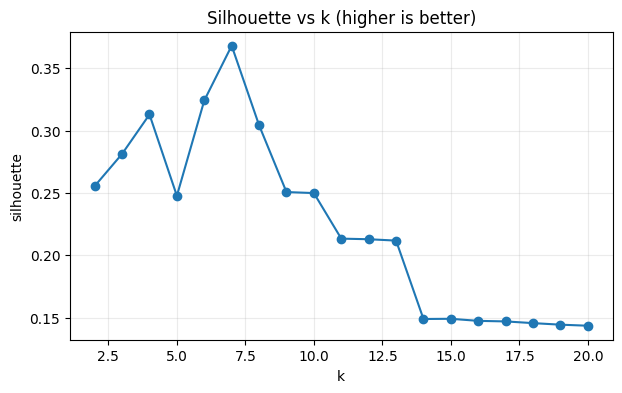

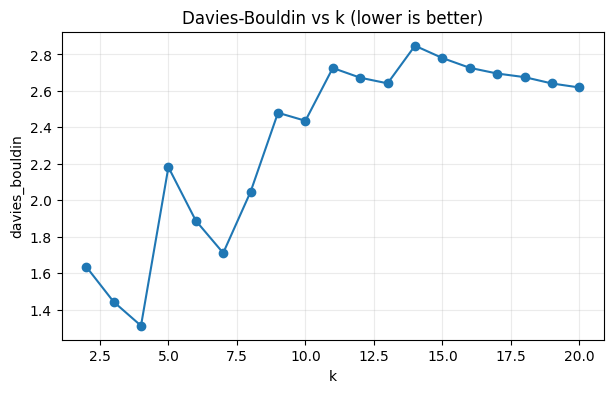

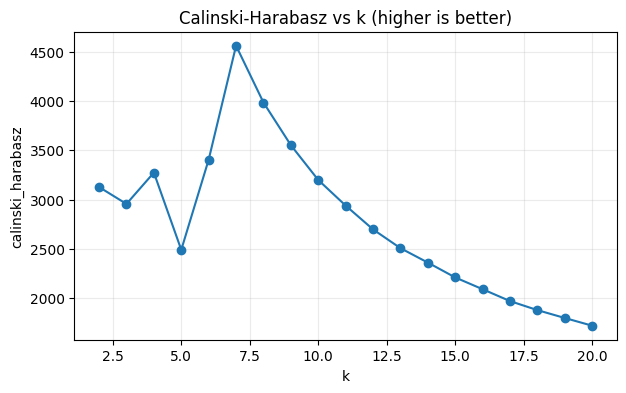

In [161]:
# Визуализация и сохранение метрик для 4го датасета
visualition_k_means(results4,"artifacts/figures/silhouette_for_KMeans_dataset_04.png")

In [180]:
#Находим оптимальное k по графику

# максимальное значение по метрике'silhouette'(оно также максимальное для Calinski-Harabasz(это видно по графикам) и совпадает со "вторым" минимумом davies_bouldin)

k_for_max_sil4 = results4['k_values'][results4['silhouette'].index(max(results4['silhouette']))] 

sil4 = results4['silhouette'][ results4['k_values'].index(k_for_max_sil4)]
db4 = results4['davies_bouldin'][ results4['k_values'].index(k_for_max_sil4)]
ch4 = results4['calinski_harabasz'][ results4['k_values'].index(k_for_max_sil4)]


print(f"Метрики для k = {k_for_max_sil4}:")
print(f"Silhouette: {sil4}")
print(f"Davies-Bouldin: {db4}")
print(f"Calinski-Harabasz: {ch4}")

Метрики для k = 7:
Silhouette: 0.36805814125837505
Davies-Bouldin: 1.7108228373873862
Calinski-Harabasz: 4558.868099573835


In [181]:
# Обновляем словарь с результатами всех метрик
json_path = Path("artifacts/metrics_summary.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)
existing_results["dt_4"]["K-means"] = {
    
        "Метрики для k": k_for_max_sil4,
        "Silhouette":sil4,
        "Davies-Bouldin": db4,
        "Calinski-Harabasz": ch4
    
}
save_json(existing_results, json_path)

In [182]:
# создание модели dbscan для 4 датасета
results_dbscan4 = eval_dbscan_grid(X4, dbscan_eps, dbscan_min_samples,pipline(num_cols4,cat_cols4))

In [184]:
metrics_dbscan(results_dbscan4)

Valid DBSCAN configs: 15


[{'params': {'eps': 2.0, 'min_samples': 10},
  'metrics': {'silhouette': 0.507439052565806,
   'davies_bouldin': 0.8240137635962008,
   'calinski_harabasz': 3916.495107696841},
  'n_clusters': 6,
  'noise_frac': 0.4885,
  'n_non_noise': np.int64(5115)},
 {'params': {'eps': 3.5, 'min_samples': 3},
  'metrics': {'silhouette': 0.44742294917270486,
   'davies_bouldin': 0.9757448045129244,
   'calinski_harabasz': 5088.87880362955},
  'n_clusters': 5,
  'noise_frac': 0.0002,
  'n_non_noise': np.int64(9998)},
 {'params': {'eps': 3.5, 'min_samples': 5},
  'metrics': {'silhouette': 0.44742294917270486,
   'davies_bouldin': 0.9757448045129244,
   'calinski_harabasz': 5088.87880362955},
  'n_clusters': 5,
  'noise_frac': 0.0002,
  'n_non_noise': np.int64(9998)},
 {'params': {'eps': 3.5, 'min_samples': 10},
  'metrics': {'silhouette': 0.44742294917270486,
   'davies_bouldin': 0.9757448045129244,
   'calinski_harabasz': 5088.87880362955},
  'n_clusters': 5,
  'noise_frac': 0.0002,
  'n_non_noise': 

Проанализировав, возьмем модель с eps=3, min_samples=3, у них не такая большая доля шума и в среднем высокие показатели метрик, также число кластеров равно 6, что ближе к прошлой модели, проверим себя , далее визуализировав.

In [231]:
# обновление словаря с результатами всех метрик
json_path = Path("artifacts/metrics_summary.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)

existing_results["dt_4"]["DBSCAN"] = {
    'metrics': {
        'silhouette':  0.42545663620108154,
        'davies_bouldin': 1.0049214984728954,
        'calinski_harabasz': 5390.375100444905
    },
    'n_clusters': 6,
    'noise_frac': 0.0082,
    'n_non_noise': 9918
}
save_json(existing_results, json_path)


Лучшей моделью для этого датасета определю модель DBSCAN, ее метрики выше и она уичтывает шум, датасет в отличие от двух предыдущих более реален и обладает большим колличесвом признаков, что делает кластеризацию качественей.Также в данном датасете уместен мой папалайн, который работает с пустыми значениями и категориальными данными,что делает его интереснее.

In [18]:
best_model4 = Pipeline(steps=[
    ('preprocessor', pipline(num_cols4,cat_cols4)),
    ('cluster', DBSCAN(eps=3, min_samples=3)) 
])
labels4 = best_model4.fit_predict(X4)

In [25]:
#создание и сохранение CSV-файла с присвоенными кластерами
dff = pd.DataFrame({
    'sample_id': y_true4,
    'cluster_label': labels4
})
dff.to_csv('artifacts/labels/labels_hw07_ds4.csv', index=False)


In [229]:
# Обновление словаря с лучшими параметрами для каждого датасета
json_path = Path("artifacts/best_configs.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)

existing_results["dt_4"] = {
    "DBSCAN":{
            'eps': 3,
            'min_samples': 3
        }
}
save_json(existing_results, json_path)


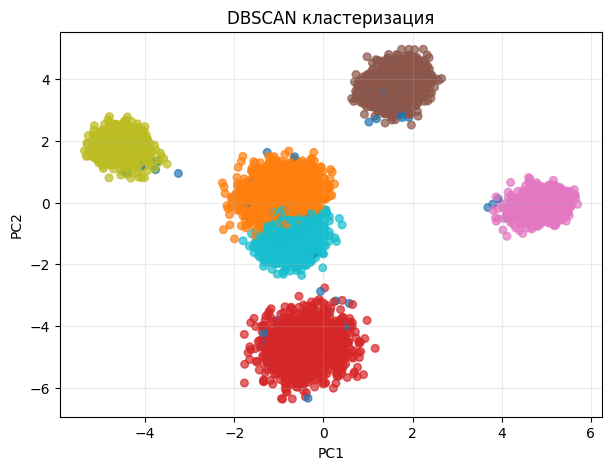

In [234]:
PCA_2D(best_model4,X4,"artifacts/figures/PCA(2D)_scatter_for_best_model_dataset_04.png")

Неплохая визуализация,но видна склейка двух классов, попробуем визуализировать через t-SNE,сначала уменьшив размерность через PCA до 30–50 компонент (ускорение и шумоподавление), а только потом запустив t-SNE.

X_transformed.shape: (10000, 42)
X_pca30.shape: (10000, 30)


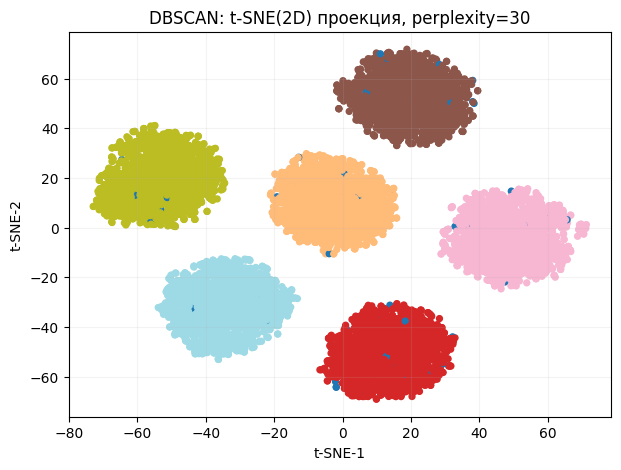

In [236]:
X_transformed = best_model4.named_steps['preprocessor'].transform(X4)
print("X_transformed.shape:", X_transformed.shape)

# PCA до 30 компонент перед t-SNE
pca30 = PCA(n_components=min(30, X_transformed.shape[1]), random_state=42)
X_pca30 = pca30.fit_transform(X_transformed)
print("X_pca30.shape:", X_pca30.shape)

def tsne_embed(X, perplexity=30, learning_rate="auto", random_state=42):
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate=learning_rate,
        init="pca",
        random_state=random_state,
        max_iter=1000,
    )
    return tsne.fit_transform(X)

# Получаем метки кластеров из DBSCAN модели
labels_dbscan = best_model4.named_steps['cluster'].labels_

# Запуск t-SNE
X_tsne = tsne_embed(X_pca30, perplexity=30)

# Визуализация
plt.figure(figsize=(7, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_dbscan, s=18, cmap='tab20')
plt.title("DBSCAN: t-SNE(2D) проекция, perplexity=30")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.grid(True, alpha=0.15)
plt.savefig("artifacts/figures/t-SNE_scatter_for_best_model_dataset_04.png", dpi=100,bbox_inches='tight')
plt.show()

Действительно, такая визуализация четко показывает разделение на 6 кластеров с небольшим шумом для каждого